# **Transfer learning with DenseNet-169 as toy model.**

### **Objectives**:

1. Build toy model with pretrained model DenseNet-169.
2. Add additional layers to the model for classification and fine-tuning.
3. Fit the model to the X-ray images.
4. Make predictions and evaluate the model.

### **Import libraries**

In [2]:
import os
import numpy as np

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress tf messages
import tensorflow as tf
print("TensorFlow version: ", tf.__version__)

import matplotlib.pyplot as plt

# Check TensorFlow is using the GPU
gpu = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

TensorFlow version:  2.12.0


### **Load the data**

In [3]:
TRAIN_DIR = "../images/train"
CLS_NAMES = ["normal", "bacteria", "virus"]
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_ds, valid_ds = tf.keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIR, 
    label_mode="int",
    class_names=CLS_NAMES,
    color_mode="rgb", 
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE, 
    shuffle=True,
    seed=42,
    validation_split=0.2, 
    subset="both")

Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.


### **Check data**

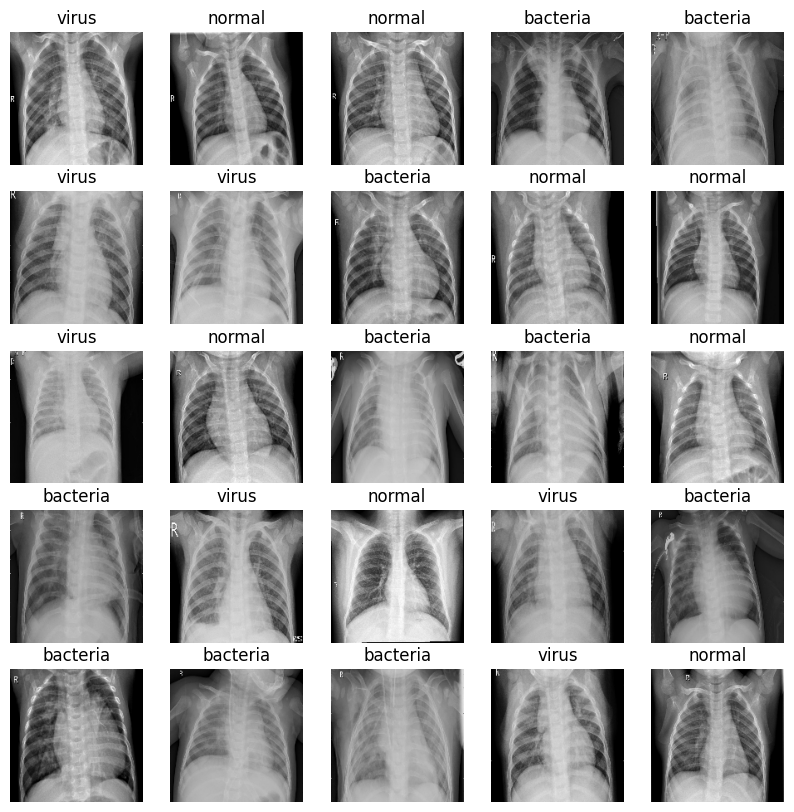

In [5]:
# Show first nine images and labels from the training set
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for img, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
# Check number of batches for training and validation sets
train_batches = tf.data.experimental.cardinality(train_ds)
valid_batches = tf.data.experimental.cardinality(valid_ds)

print("Number of training batches: %d" % train_batches)
print("Number of validation batches: %d" % valid_batches)

Number of training batches: 118
Number of validation batches: 30


### **Configure datasets for performance**

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)

### **Create DenseNet-169 base model**

In [29]:
# Create base model from pretrained model DenseNet-169
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.densenet.DenseNet169(input_shape=IMG_SHAPE,
                                                        include_top=False,
                                                        weights="imagenet")

# Freeze convolutional base
base_model.trainable = False 

In [30]:
# Instantiate preprocessing method
preprocess_input = tf.keras.applications.densenet.preprocess_input

In [31]:
# Extract features
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(image_batch.shape, "-->", feature_batch.shape)

# This converts each (160, 160, 3) image to a (5, 5, 1664) block of features

(32, 160, 160, 3) --> (32, 5, 5, 1664)


In [32]:
# Check base model architecture
base_model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 166, 166, 3)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 80, 80, 64)   9408        ['zero_padding2d_2[0][0]']       
                                                                                        

#### **Add a classification head**

In [33]:
# Add global averaging
global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_avg = global_avg_layer(feature_batch)
print("Feature batch (not averaged) shape:", feature_batch.shape)
print("Feature batch (averaged) shape:", feature_batch_avg.shape)

# this averages over the (5 x 5) spatial locations...
# converting the features to a single 1664-element vector per image

clf_layer = tf.keras.layers.Dense(3, activation="softmax")
pred_batch = clf_layer(feature_batch_avg)
print("Prediction batch shape:", pred_batch.shape)

# the dense layer converts the features into a (,3) output...
# representing the probabilities of each predicted class

Feature batch (not averaged) shape: (32, 5, 5, 1664)
Feature batch (averaged) shape: (32, 1664)
Prediction batch shape: (32, 3)


#### **Build model with functional API**

In [34]:
inputs = tf.keras.Input(shape=IMG_SHAPE)

x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_avg_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = clf_layer(x)

model = tf.keras.Model(inputs, outputs)

#### **Compile model**

In [35]:
base_lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 densenet169 (Functional)    (None, 5, 5, 1664)        12642880  
                                                           

#### **Train model**

In [36]:
# Evaluate model without training
loss_0, accuracy_0 = model.evaluate(valid_ds)

print("initial loss: {:.2f}".format(loss_0))
print("initial accuracy: {:.2f}".format(accuracy_0))

30/30 [==============================] - 18s 388ms/step - loss: 2.5418 - accuracy: 0.2821
initial loss: 2.54
initial accuracy: 0.28


In [41]:
# Train model for ten epochs
epochs = 10

history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=valid_ds, 
                    verbose=1)

# ~80.02% was achieved on the validation set

Epoch 1/10
118/118 [==============================] - 43s 362ms/step - loss: 0.6648 - accuracy: 0.7292 - val_loss: 0.5854 - val_accuracy: 0.7596
Epoch 2/10
118/118 [==============================] - 63s 531ms/step - loss: 0.6271 - accuracy: 0.7351 - val_loss: 0.5681 - val_accuracy: 0.7671
Epoch 3/10
118/118 [==============================] - 69s 579ms/step - loss: 0.6075 - accuracy: 0.7473 - val_loss: 0.5565 - val_accuracy: 0.7692
Epoch 4/10
118/118 [==============================] - 62s 516ms/step - loss: 0.5893 - accuracy: 0.7583 - val_loss: 0.5412 - val_accuracy: 0.7810
Epoch 5/10
118/118 [==============================] - 62s 516ms/step - loss: 0.5731 - accuracy: 0.7601 - val_loss: 0.5256 - val_accuracy: 0.7821
Epoch 6/10
118/118 [==============================] - 60s 499ms/step - loss: 0.5544 - accuracy: 0.7692 - val_loss: 0.5222 - val_accuracy: 0.7959
Epoch 7/10
118/118 [==============================] - 58s 488ms/step - loss: 0.5509 - accuracy: 0.7748 - val_loss: 0.5178 - val_ac

#### **Learning curves**

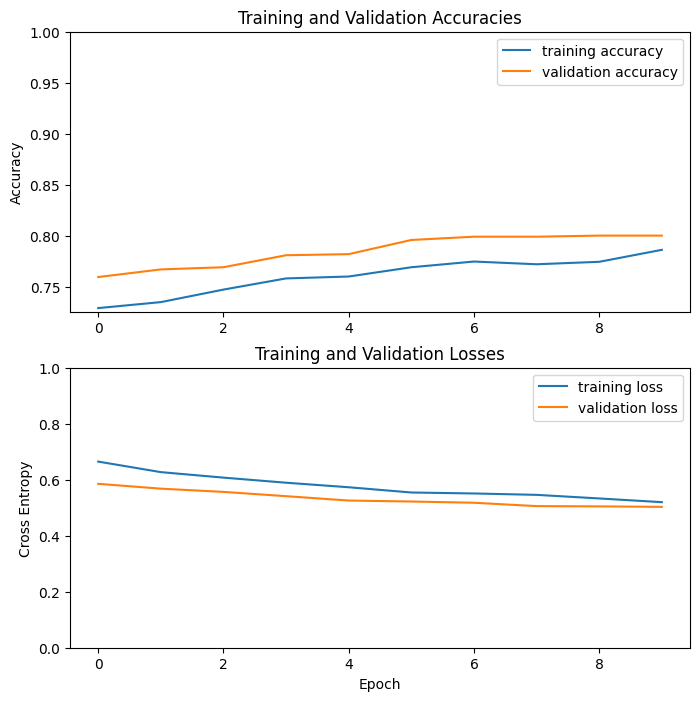

In [55]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label="training accuracy")
plt.plot(val_acc, label="validation accuracy")
plt.legend()
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Accuracies")

plt.subplot(2, 1, 2)
plt.plot(loss, label="training loss")
plt.plot(val_loss, label="validation loss")
plt.legend()
plt.ylabel("Cross Entropy")
plt.ylim(0, 1.0)
plt.title("Training and Validation Losses")
plt.xlabel("Epoch")

plt.show()

### **Fine tuning**

In [47]:
# Unfreeze top layers of model
base_model.trainable = True

In [49]:
# Check base model layers
print("Number of layers in base model:", len(base_model.layers))

fine_tune_at = 100

# Freeze all layers before 100 layers
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in base model: 595


#### **Recompile model**

In [51]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_lr/10),
              metrics=["accuracy"])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 densenet169 (Functional)    (None, 5, 5, 1664)        12642880  
                                                           

#### **Continue training model**

In [ ]:
fine_tune_epochs = 10
total_epochs = epochs + fine_tune_epochs

history_tuned = model.fit(train_ds,
                          epochs=total_epochs,
                          initial_epoch=history.epoch[-1],
                          validation_data=valid_ds,
                          verbose=1)

In [ ]:
# Update metrics
acc += history_tuned.history['accuracy']
val_acc += history_tuned.history['val_accuracy']

loss += history_tuned.history['loss']
val_loss += history_tuned.history['val_loss']